2025-05-27 22:46:09,733 [DEBUG] Requesting embedding for drug 'Lisinopril' using model 'llama3:8b'
2025-05-27 22:46:09,750 [DEBUG] Starting new HTTP connection (1): localhost:11434
2025-05-27 22:46:10,025 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:46:10,027 [INFO] Embedding for drug 'Lisinopril' received (vector length: 4096)
2025-05-27 22:46:10,042 [DEBUG] Requesting embedding for drug 'Enalapril' using model 'llama3:8b'
2025-05-27 22:46:10,046 [DEBUG] Starting new HTTP connection (1): localhost:11434


2025-05-27 22:46:10,248 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:46:10,251 [INFO] Embedding for drug 'Enalapril' received (vector length: 4096)
2025-05-27 22:46:10,253 [DEBUG] Requesting embedding for drug 'Ramipril' using model 'llama3:8b'
2025-05-27 22:46:10,256 [DEBUG] Starting new HTTP connection (1): localhost:11434
2025-05-27 22:46:10,415 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:46:10,416 [INFO] Embedding for drug 'Ramipril' received (vector length: 4096)
2025-05-27 22:46:10,418 [DEBUG] Requesting embedding for drug 'Captopril' using model 'llama3:8b'
2025-05-27 22:46:10,422 [DEBUG] Starting new HTTP connection (1): localhost:11434
2025-05-27 22:46:10,528 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:46:10,530 [INFO] Embedding for drug 'Captopril' received (vector length: 4096)
2025-05-27 22:46:10,531 [DEBUG] Requesting embedding for drug 'Metoprolol' using model 'll

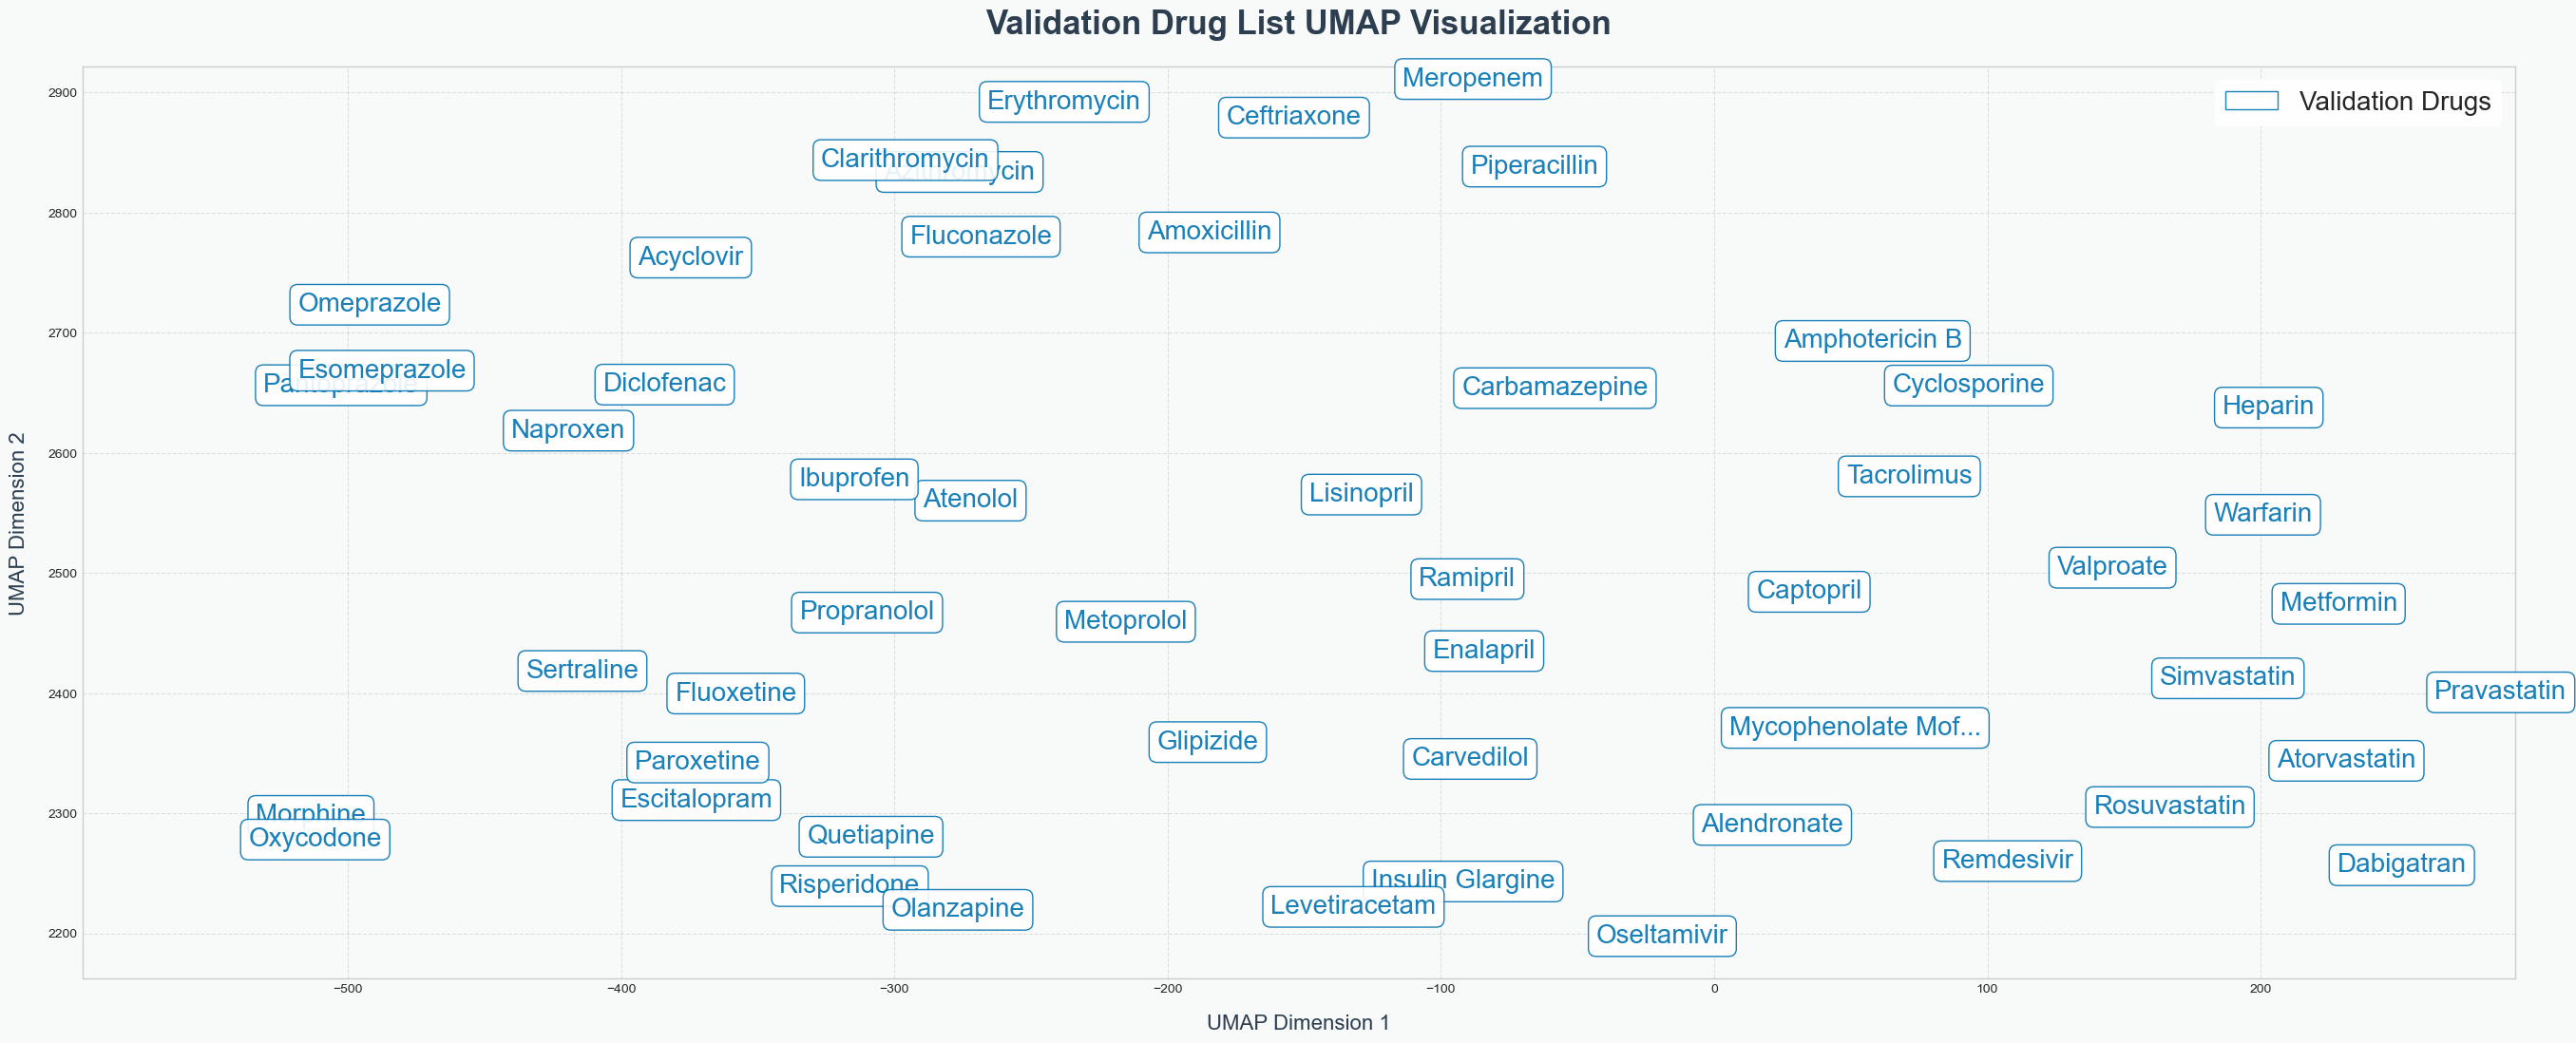

In [ ]:
import json
import requests
import logging
import numpy as np
import os
import umap.umap_ as umap
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.patches import Patch
from matplotlib.text import Text
from matplotlib.transforms import Bbox
import matplotlib.transforms as transforms

# Configure logging
logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.DEBUG
)
logger = logging.getLogger(__name__)

# URL to the local Ollama embedding API endpoint
EMBED_URL = "http://localhost:11434/api/embed"

# Set the style for the plot
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Color scheme for validation drugs
VALIDATION_STYLE = {
    "color": "#0072B2",  # Blue
    "name": "Validation Drugs"
}

def get_embedding_for_drug(drug: str, model: str) -> np.ndarray:
    """
    Get the embedding of a drug name by calling the Ollama embedding API.
    
    Args:
        drug (str): The drug name.
        model (str): The model to use for embeddings.
    
    Returns:
        np.ndarray: The embedding vector as a NumPy array.
    """
    payload = {
        "model": model,
        "input": drug
    }
    logger.debug("Requesting embedding for drug '%s' using model '%s'", drug, model)
    try:
        response = requests.post(EMBED_URL, json=payload)
        response.raise_for_status()
        data = response.json()
        embedding_list = data["embeddings"][0]
        logger.info("Embedding for drug '%s' received (vector length: %d)", drug, len(embedding_list))
        return np.array(embedding_list)
    except requests.RequestException as err:
        logger.error("Error fetching embedding for drug '%s': %s", drug, str(err))
        return None

def embed_drugs(drug_list: list, model: str) -> dict:
    """
    Get embeddings for all drugs in the provided list.
    
    Args:
        drug_list (list): List of drug names.
        model (str): Embedding model to use.
    
    Returns:
        dict: Mapping from drug name to its embedding.
    """
    embeddings = {}
    for drug in drug_list:
        embedding = get_embedding_for_drug(drug, model)
        if embedding is not None:
            embeddings[drug] = embedding
        else:
            logger.warning("Skipping drug '%s' due to failed embedding.", drug)
    return embeddings

def get_text_bbox(text: Text) -> Bbox:
    """Get the bounding box of a text object in display coordinates."""
    renderer = text.figure.canvas.get_renderer()
    bbox = text.get_window_extent(renderer)
    return bbox

def check_overlap(bbox1: Bbox, bbox2: Bbox, padding: float = 5) -> bool:
    """Check if two bounding boxes overlap with padding."""
    return (bbox1.x0 - padding < bbox2.x1 + padding and
            bbox1.x1 + padding > bbox2.x0 - padding and
            bbox1.y0 - padding < bbox2.y1 + padding and
            bbox1.y1 + padding > bbox2.y0 - padding)

def find_optimal_position(text: Text, existing_texts: List[Text], 
                         x: float, y: float, ax: plt.Axes,
                         max_attempts: int = 8) -> Tuple[float, float]:
    """Find an optimal position for a text label that minimizes overlap."""
    angles = np.linspace(0, 2*np.pi, max_attempts, endpoint=False)
    distances = [15, 30, 45]
    
    best_pos = (x, y)
    min_overlaps = float('inf')
    
    for distance in distances:
        for angle in angles:
            dx = distance * np.cos(angle)
            dy = distance * np.sin(angle)
            new_x = x + dx
            new_y = y + dy
            
            text.set_position((new_x, new_y))
            new_bbox = get_text_bbox(text)
            
            overlaps = sum(1 for existing in existing_texts 
                         if check_overlap(new_bbox, get_text_bbox(existing)))
            
            if overlaps < min_overlaps:
                min_overlaps = overlaps
                best_pos = (new_x, new_y)
                
            if overlaps == 0:
                return best_pos
    
    return best_pos

if __name__ == "__main__":
    # Load validation drug list
    with open("drug_lists/validation_drug_list.json", 'r') as file:
        drug_list = json.load(file)
    
    # Specify the embedding model
    embedding_model = "llama3:8b"
    
    # Get embeddings for all drugs
    embeddings = embed_drugs(drug_list, embedding_model)
    
    # Prepare data for UMAP
    drug_names = list(embeddings.keys())
    embedding_vectors = np.vstack(list(embeddings.values()))
    
    # Apply UMAP
    umap_model = umap.UMAP(n_components=2, random_state=42)
    logger.info("Fitting UMAP on %d embeddings for visualization.", embedding_vectors.shape[0])
    embedding_2d = umap_model.fit_transform(embedding_vectors)
    logger.info("UMAP reduction complete. Reduced shape: %s", embedding_2d.shape)

    # Scale up the embeddings
    scale_factor = 200
    embedding_2d = embedding_2d * scale_factor

    # Create figure
    plt.figure(figsize=(32, 12))
    ax = plt.gca()
    
    # Set background color
    ax.set_facecolor('#F8F9F9')
    plt.gcf().set_facecolor('#F8F9F9')

    # Plot invisible points
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0)

    # Compute jitter factors
    jitter_factor_x = (np.max(embedding_2d[:, 0]) - np.min(embedding_2d[:, 0])) * 0.05
    jitter_factor_y = (np.max(embedding_2d[:, 1]) - np.min(embedding_2d[:, 1])) * 0.05

    # Function to truncate long labels
    def truncate_label(label: str, max_length: int = 20) -> str:
        return label if len(label) <= max_length else label[:max_length-3] + "..."

    # Annotate each point with its drug name
    existing_texts = []
    for i, drug in enumerate(drug_names):
        x, y = embedding_2d[i, 0], embedding_2d[i, 1]
        
        # Add small random jitter
        x_jitter = x + np.random.uniform(-jitter_factor_x, jitter_factor_x)
        y_jitter = y + np.random.uniform(-jitter_factor_y, jitter_factor_y)
        
        # Create text object with truncated label
        text = plt.text(x_jitter, y_jitter, truncate_label(drug),
                       color=VALIDATION_STYLE["color"],
                       fontsize=20,
                       fontweight='medium',
                       alpha=0.9,
                       bbox=dict(facecolor='white', 
                                edgecolor=VALIDATION_STYLE["color"],
                                alpha=0.9,
                                pad=1.5,
                                boxstyle='round,pad=0.3'))
        existing_texts.append(text)

    # Improve title and labels styling
    plt.title("Validation Drug List UMAP Visualization",
             pad=25,
             fontsize=25,
             fontweight='bold',
             color='#2C3E50')
    
    plt.xlabel("UMAP Dimension 1",
              labelpad=15,
              fontsize=16,
              color='#2C3E50')
    plt.ylabel("UMAP Dimension 2",
              labelpad=15,
              fontsize=16,
              color='#2C3E50')

    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.3, color='#95A5A6')
    
    # Create legend
    legend_handles = [
        Patch(facecolor='white',
              edgecolor=VALIDATION_STYLE["color"],
              label=VALIDATION_STYLE["name"],
              alpha=0.9)
    ]
    
    legend = plt.legend(handles=legend_handles,
                       loc="best",
                       fontsize=20,
                       frameon=True,
                       facecolor='white',
                       edgecolor='none',
                       framealpha=0.9)
    
    # Adjust layout
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # Save with high DPI
    output_plot = "validation_drugs_umap.png"
    plt.savefig(output_plot,
                dpi=600,
                bbox_inches='tight',
                facecolor='#F8F9F9',
                edgecolor='none')
    logger.info("UMAP plot saved to %s", output_plot)
    plt.show()


# Pharmacological Groupings for validation of embedding approach

# ACE Inhibitors
# Lisinopril, Enalapril, Ramipril, Captopril

# Beta Blockers
# Metoprolol, Propranolol, Atenolol, Carvedilol

# Statins (HMG-CoA Reductase Inhibitors)
# Atorvastatin, Simvastatin, Rosuvastatin, Pravastatin

# Beta-lactam Antibiotics
# Amoxicillin, Ceftriaxone, Piperacillin, Meropenem

# Macrolide Antibiotics
# Azithromycin, Clarithromycin, Erythromycin

# Selective Serotonin Reuptake Inhibitors (SSRIs)
# Fluoxetine, Sertraline, Escitalopram, Paroxetine

# Antipsychotics (Atypical)
# Risperidone, Olanzapine, Quetiapine

# Antidiabetics
# Metformin, Glipizide, Insulin Glargine

# Antiepileptics
# Valproate, Carbamazepine, Levetiracetam

# Immunosuppressants
# Cyclosporine, Tacrolimus, Mycophenolate Mofetil

# Antivirals
# Acyclovir, Oseltamivir, Remdesivir

# Non-Steroidal Anti-Inflammatory Drugs (NSAIDs)
# Ibuprofen, Naproxen, Diclofenac

# Opioid Analgesics
# Morphine, Oxycodone

# Anticoagulants
# Warfarin, Heparin, Dabigatran

# Proton Pump Inhibitors (PPIs)
# Omeprazole, Pantoprazole, Esomeprazole

# Antifungals
# Fluconazole, Amphotericin B

# Bisphosphonates
# Alendronate

2025-05-27 22:49:02,135 [INFO] Loaded 50 drugs for approach 'zero_shot' from drug_lists/zero_shot_prompt_top_50_drugs.json
2025-05-27 22:49:02,139 [DEBUG] Requesting embedding for drug 'Aducanumab' using model 'llama3:8b'
2025-05-27 22:49:02,148 [DEBUG] Starting new HTTP connection (1): localhost:11434
2025-05-27 22:49:02,377 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:49:02,379 [INFO] Embedding for drug 'Aducanumab' received (vector length: 4096)
2025-05-27 22:49:02,380 [DEBUG] Requesting embedding for drug 'Lecanemab' using model 'llama3:8b'
2025-05-27 22:49:02,381 [DEBUG] Starting new HTTP connection (1): localhost:11434
2025-05-27 22:49:02,490 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:49:02,492 [INFO] Embedding for drug 'Lecanemab' received (vector length: 4096)
2025-05-27 22:49:02,493 [DEBUG] Requesting embedding for drug '6-[3-(4-Morpholinyl)Propyl]-2-(3-Nitrophenyl)-5-Thioxo-5,6,-Dihydro-7h-Thienol[2',3'

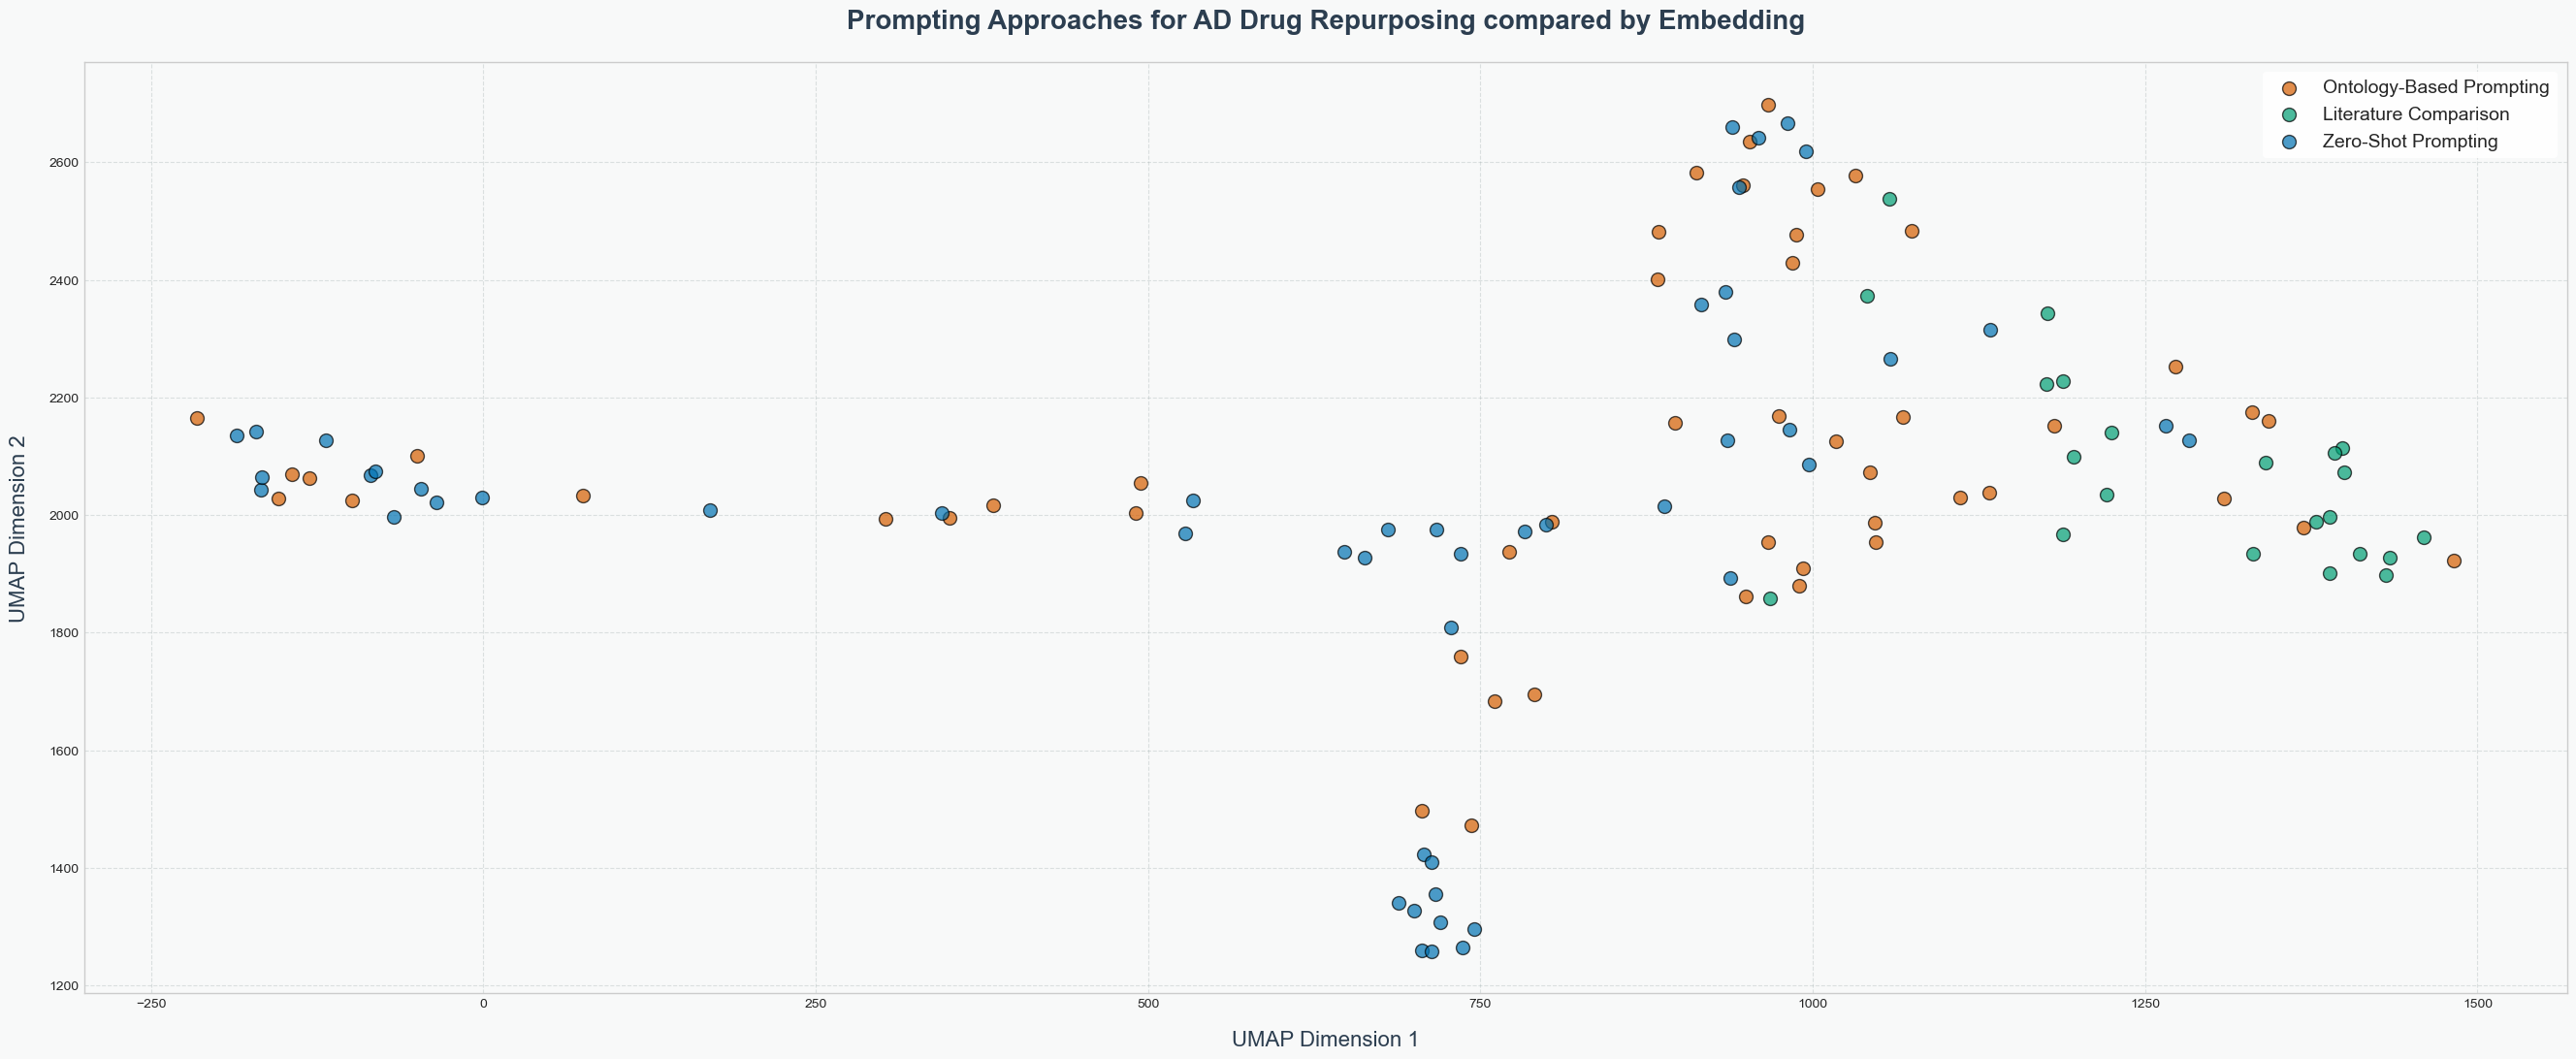

In [7]:
import json
import requests
import logging
import numpy as np
import os
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configure logging for detailed internal state.
logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.DEBUG  # Change to INFO for less verbosity if desired
)
logger = logging.getLogger(__name__)

# URL to the local Ollama embedding API endpoint.
EMBED_URL = "http://localhost:11434/api/embed"

# Set the style for the plot
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Color-blind friendly palette
APPROACH_STYLES = {
    "zero_shot": {
        "color": "#0072B2",  # Blue
        "name": "Zero-Shot Prompting"
    },
    "ontological_prompt": {
        "color": "#D55E00",  # Orange
        "name": "Ontology-Based Prompting"
    },
    "literature": {
        "color": "#009E73",  # Green
        "name": "Literature Comparison"
    }
}

def get_embedding_for_drug(drug: str, model: str) -> np.ndarray:
    """
    Get the embedding of a drug name by calling the Ollama embedding API.
    
    Args:
        drug (str): The drug name.
        model (str): The model to use for embeddings (e.g. "llama3:8b").
    
    Returns:
        np.ndarray: The embedding vector as a NumPy array.
    """
    payload = {
        "model": model,
        "input": drug
    }
    logger.debug("Requesting embedding for drug '%s' using model '%s'", drug, model)
    try:
        response = requests.post(EMBED_URL, json=payload)
        response.raise_for_status()
        data = response.json()
        # Assuming the embedding is in the first element of "embeddings"
        embedding_list = data["embeddings"][0]
        logger.info("Embedding for drug '%s' received (vector length: %d)", drug, len(embedding_list))
        return np.array(embedding_list)
    except requests.RequestException as err:
        logger.error("Error fetching embedding for drug '%s': %s", drug, str(err))
        return None

def embed_top_100_drugs(drug_list: list, model: str) -> dict:
    """
    For each drug in the provided list, call the Ollama API to get an embedding.
    
    Args:
        drug_list (list): List of drug names.
        model (str): Embedding model to use.
    
    Returns:
        dict: Mapping from drug name to its embedding (as a NumPy array).
    """
    embeddings = {}
    for drug in drug_list:
        embedding = get_embedding_for_drug(drug, model)
        if embedding is not None:
            embeddings[drug] = embedding
        else:
            logger.warning("Skipping drug '%s' due to failed embedding.", drug)
    return embeddings

def run_through_all_approaches(approach_files: dict, model: str) -> dict:
    """
    Process all approaches by loading the respective JSON files containing top 100 drugs,
    generating embeddings for each, and storing the results.
    
    Args:
        approach_files (dict): Mapping of approach names to JSON filenames.
        model (str): Embedding model to use.
    
    Returns:
        dict: Mapping from approach name to a dictionary of (drug -> embedding) pairs.
    """
    all_approach_embeddings = {}
    
    for approach, file_path in approach_files.items():
        if not os.path.exists(file_path):
            logger.error("File %s for approach '%s' not found!", file_path, approach)
            continue
        
        with open(file_path, 'r') as file:
            data = json.load(file)
            # Handle both list and dictionary structures
            if isinstance(data, dict):
                drug_list = list(data.keys())
            else:
                # Assume it's a list of drug names
                drug_list = data
            logger.info("Loaded %d drugs for approach '%s' from %s", len(drug_list), approach, file_path)
        
        embeddings = embed_top_100_drugs(drug_list, model)
        all_approach_embeddings[approach] = embeddings
    return all_approach_embeddings

def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """
    Calculate the cosine similarity between two embedding vectors.
    
    Args:
        vec1 (np.ndarray): First embedding vector.
        vec2 (np.ndarray): Second embedding vector.
    
    Returns:
        float: Cosine similarity value (range [-1, 1]).
    """
    logger.debug("Calculating cosine similarity.")
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        logger.error("Zero norm encountered.")
        return 0.0
    similarity = dot_product / (norm1 * norm2)
    logger.debug("Cosine similarity: %f", similarity)
    return similarity

def calculate_distance_between_approach_and_pubmed(approach_embeddings: dict, pubmed_embeddings: dict) -> float:
    """
    For each drug in an approach, compute the minimum cosine distance 
    (1 - cosine similarity) to any drug in the PubMed validation set,
    then compute the aggregate (average) minimal distance.
    
    Args:
        approach_embeddings (dict): Mapping of drug to embedding for one approach.
        pubmed_embeddings (dict): Mapping of drug to embedding for PubMed validation.
    
    Returns:
        float: The aggregated minimal distance (lower means closer).
    """
    distances = []
    for drug, emb in approach_embeddings.items():
        min_distance = float('inf')
        for pubmed_drug, pubmed_emb in pubmed_embeddings.items():
            similarity = cosine_similarity(emb, pubmed_emb)
            distance = 1 - similarity  # convert similarity to distance
            if distance < min_distance:
                min_distance = distance
        distances.append(min_distance)
        logger.debug("Drug '%s': minimal cosine distance to PubMed = %f", drug, min_distance)
    
    if distances:
        agg_distance = np.mean(distances)
    else:
        agg_distance = float('inf')
    logger.info("Aggregated minimal distance (avg) for approach: %f", agg_distance)
    return agg_distance

def find_approach_closest_to_pubmed_validation(all_approach_embeddings: dict, pubmed_embeddings: dict) -> None:
    """
    For each approach, calculate the aggregate distance between its drug embeddings
    and the PubMed validation embeddings. Then compare these distances
    to determine which approach is closest to the PubMed validation set.
    
    Args:
        all_approach_embeddings (dict): Mapping of approach names to embeddings dict (drug -> embedding).
        pubmed_embeddings (dict): Embeddings of PubMed validation drugs.
    
    Prints:
        The aggregated distances per approach and the approach with the smallest distance.
    """
    approach_distances = {}
    for approach, embeddings in all_approach_embeddings.items():
        agg_distance = calculate_distance_between_approach_and_pubmed(embeddings, pubmed_embeddings)
        approach_distances[approach] = agg_distance
        logger.info("Approach '%s' aggregated distance: %f", approach, agg_distance)
    
    closest_approach = min(approach_distances, key=approach_distances.get)
    logger.info("Approach closest to PubMed validation: %s", closest_approach)
    
    print("Aggregated minimal distances (lower means closer to PubMed):")
    for approach, distance in approach_distances.items():
        print(f"{approach}: {distance:.4f}")
    print(f"\nApproach with drugs closest to PubMed validation: {closest_approach}")

def combine_embeddings_for_visualization(all_embeddings: dict) -> tuple:
    """
    Combine embeddings and their labels for all approaches,
    preparing data for visualization.
    
    Args:
        all_embeddings (dict): Mapping from approach name to (drug -> embedding) dict.
        
    Returns:
        tuple: (combined_embeddings, combined_labels, combined_drug_names)
    """
    combined_embeddings = []
    combined_labels = []
    combined_drug_names = []
    
    for approach, emb_dict in all_embeddings.items():
        for drug, emb in emb_dict.items():
            combined_embeddings.append(emb)
            combined_labels.append(approach)
            combined_drug_names.append(drug)
    
    if combined_embeddings:
        combined_embeddings = np.vstack(combined_embeddings)
        logger.info("Combined %d embeddings for visualization.", combined_embeddings.shape[0])
    return combined_embeddings, combined_labels, combined_drug_names

if __name__ == "__main__":
    # Define the JSON file paths for the approaches.
    approach_files = {
        "zero_shot": "drug_lists/zero_shot_prompt_top_50_drugs.json",
        "ontological_prompt": "drug_lists/ontological_prompt_top_50_drugs.json",
        "literature": "drug_lists/cummings_eta_al_AD_DR_candidates.json",
    }
    
    # Specify the embedding model.
    embedding_model = "llama3:8b"
    
    # Run the pipeline.
    all_embeddings = run_through_all_approaches(approach_files, embedding_model)
    
    # -----------------------------
    # Visualization using UMAP
    # -----------------------------
    combined_embeddings, labels, drug_names = combine_embeddings_for_visualization(all_embeddings)
    
    # Apply UMAP to reduce the embeddings to 2 dimensions.
    umap_model = umap.UMAP(n_components=2, random_state=42)
    logger.info("Fitting UMAP on %d embeddings for visualization.", combined_embeddings.shape[0])
    embedding_2d = umap_model.fit_transform(combined_embeddings)
    logger.info("UMAP reduction complete. Reduced shape: %s", embedding_2d.shape)
    
    # Scale up the embeddings to spread them out more
    scale_factor = 200
    embedding_2d = embedding_2d * scale_factor

    # Create figure with a broader aspect ratio
    plt.figure(figsize=(32, 12))
    ax = plt.gca()
    
    # Set background color
    ax.set_facecolor('#F8F9F9')
    plt.gcf().set_facecolor('#F8F9F9')
    
    # Plot points with different colors per approach
    for approach in set(labels):
        indices = [i for i, label in enumerate(labels) if label == approach]
        style = APPROACH_STYLES[approach]
        plt.scatter(embedding_2d[indices, 0], embedding_2d[indices, 1],
                   c=style["color"],
                   label=style["name"],
                   alpha=0.7,
                   edgecolors='k',
                   s=100)  # Increased marker size
    
    # Improve title and labels styling
    plt.title("Prompting Approaches for AD Drug Repurposing compared by Embedding",
             pad=25,
             fontsize=20,
             fontweight='bold',
             color='#2C3E50')
    
    plt.xlabel("UMAP Dimension 1",
              labelpad=15,
              fontsize=16,
              color='#2C3E50')
    plt.ylabel("UMAP Dimension 2",
              labelpad=15,
              fontsize=16,
              color='#2C3E50')

    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.3, color='#95A5A6')
    
    # Create legend with improved styling
    legend = plt.legend(loc="best",
                       fontsize=14,
                       frameon=True,
                       facecolor='white',
                       edgecolor='none',
                       framealpha=0.9)
    
    # Adjust layout with more space
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # Save with high DPI and transparent background
    output_plot = "approaches_umap_plot.png"
    plt.savefig(output_plot,
                dpi=600,
                bbox_inches='tight',
                facecolor='#F8F9F9',
                edgecolor='none')
    logger.info("UMAP plot saved to %s", output_plot)
    plt.show()



##########
# PLEASE NOTE - FOR FITTING THE LAYOUT OF THE MANUSCRIPT THE SIZE OF THE PLOT AND ITS WIDTH WERE MANUALLY ADJUSTED. 
# YOU CAN REPLICATE THIS BY RUNNING THE SCRIPT AND THEN HAVING A LOOK AT THE OUTPUT PLOT IN THE INTERACTIVE PLOT VIEWER.
# WHILE THE CLUSTERING OF DRUG IS THE SAME, THE LAYOUT MAY APPEAR DIFFERENTLY DEPENDING ON THE LAYOUT OF YOUR SCREEN.
# THE PLOT SAVED TO THIS IPYNB FILE DIFFERS SLIGHTLY FROM THE ONE IN THE MANUSCRIPT AS THE LAYOUT WAS MANUALLY ADJUSTED.
# IF YOU COMPARE THE CLUSTERING OF DRUGS BETWEEN THE PLOT IN THE MANUSCRIPT AND THIS IPYNB FILE YOU WILL SEE THAT THEY ARE IDENTICAL.
# THIS IS EVEN CLEARER ON THE PLOT BELOW THAT ALSO SHOWS THE ANNOTATION OF THE DRUG NAMES. (BUT IS OTHERWISE IDENTICAL)
##########

2025-05-27 22:41:53,020 [INFO] Loaded 50 drugs for approach 'zero_shot' from drug_lists/zero_shot_prompt_top_50_drugs.json
2025-05-27 22:41:53,021 [DEBUG] Requesting embedding for drug 'Aducanumab' using model 'llama3:8b'
2025-05-27 22:41:53,086 [DEBUG] Starting new HTTP connection (1): localhost:11434
2025-05-27 22:41:55,627 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:41:55,632 [INFO] Embedding for drug 'Aducanumab' received (vector length: 4096)
2025-05-27 22:41:55,635 [DEBUG] Requesting embedding for drug 'Lecanemab' using model 'llama3:8b'
2025-05-27 22:41:55,639 [DEBUG] Starting new HTTP connection (1): localhost:11434
2025-05-27 22:41:55,759 [DEBUG] http://localhost:11434 "POST /api/embed HTTP/1.1" 200 None
2025-05-27 22:41:55,762 [INFO] Embedding for drug 'Lecanemab' received (vector length: 4096)
2025-05-27 22:41:55,763 [DEBUG] Requesting embedding for drug '6-[3-(4-Morpholinyl)Propyl]-2-(3-Nitrophenyl)-5-Thioxo-5,6,-Dihydro-7h-Thienol[2',3'

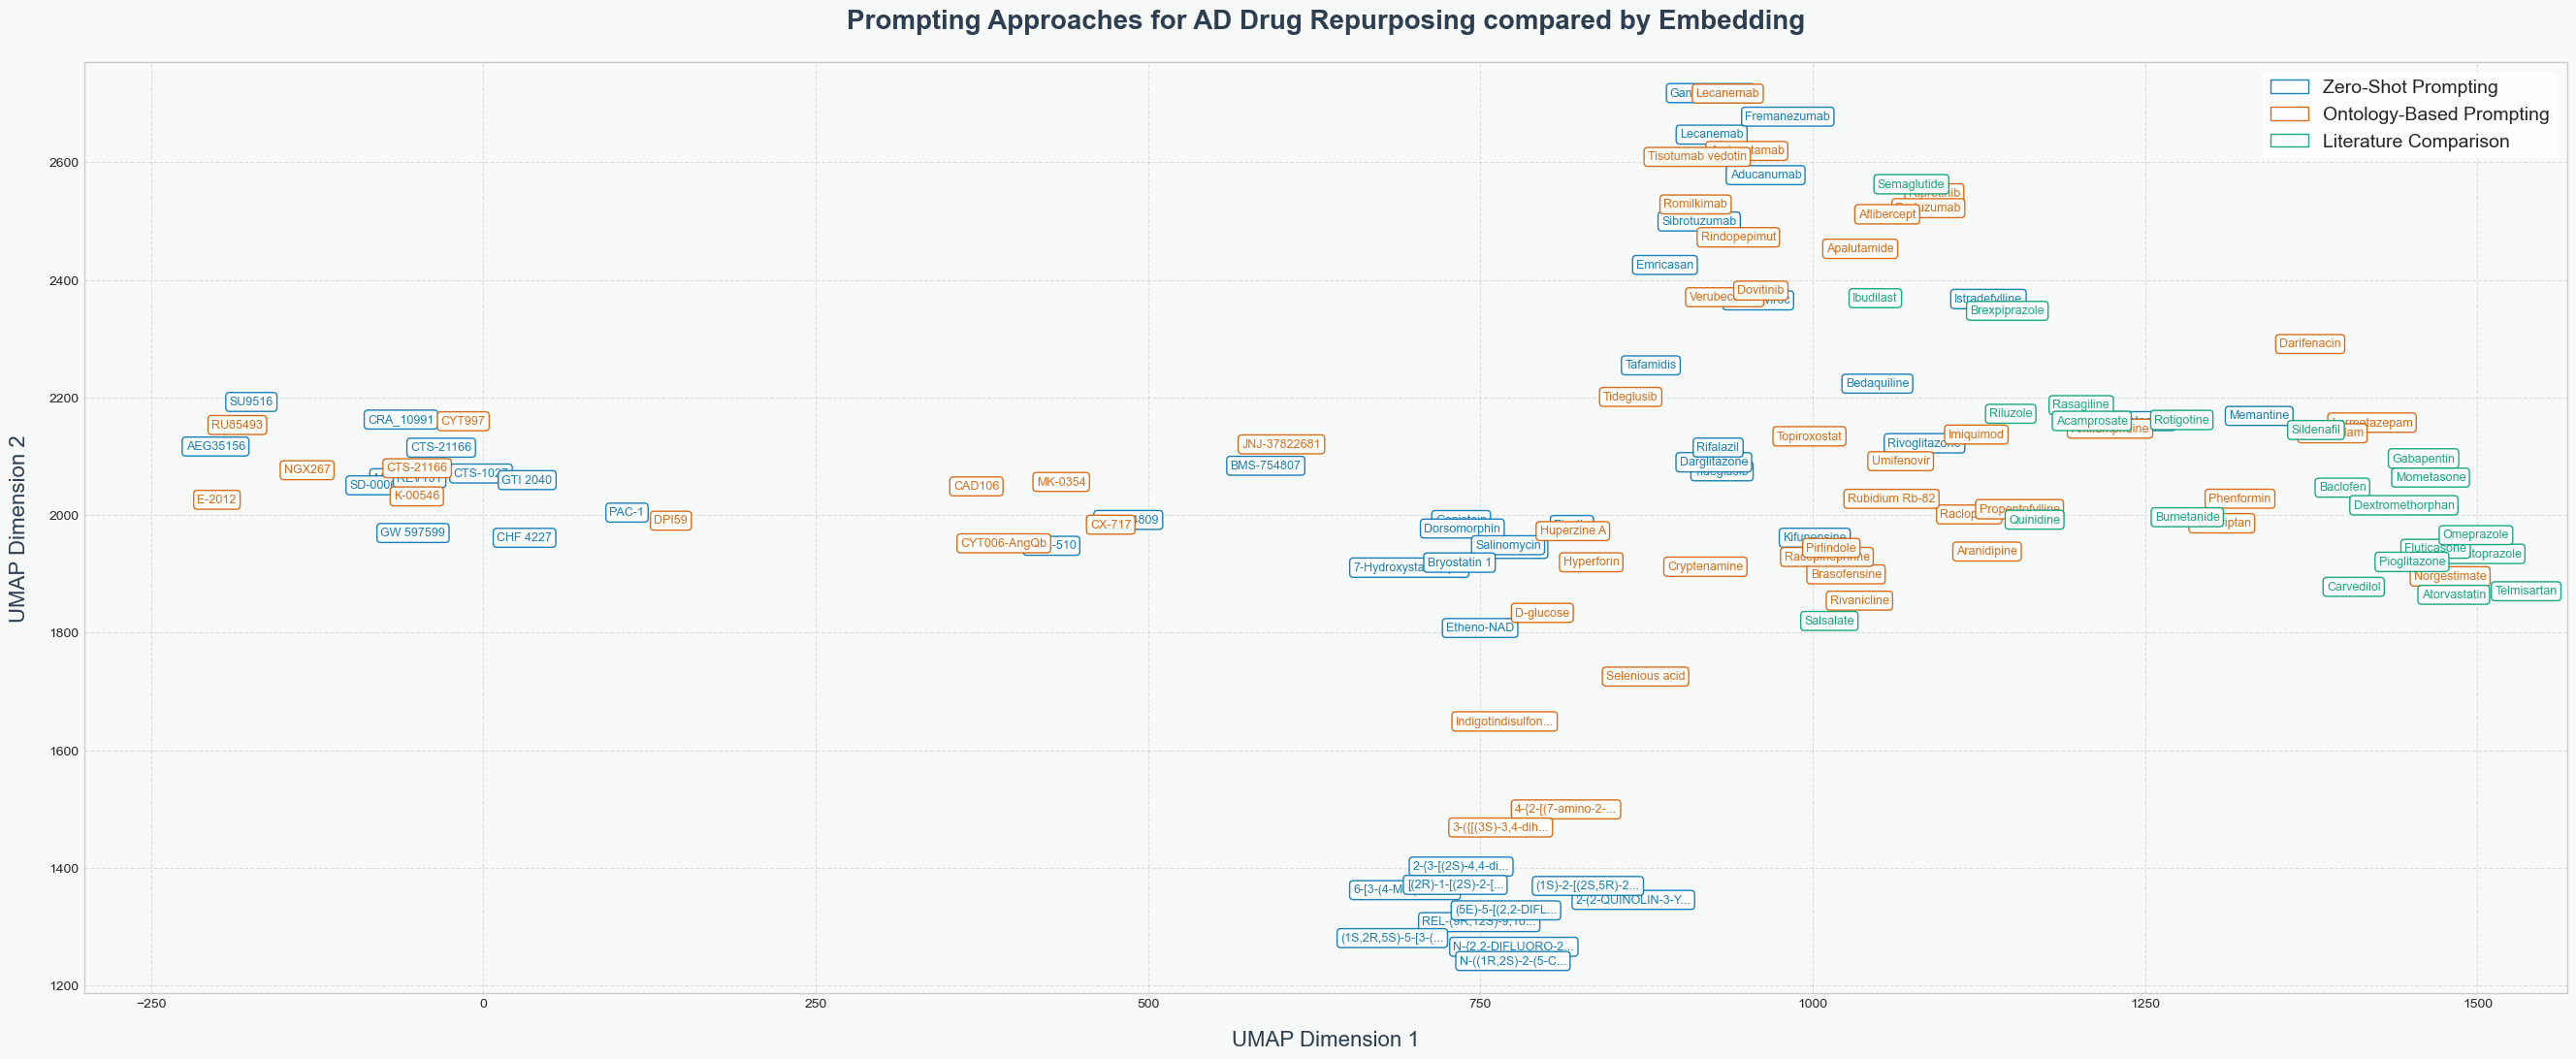

In [3]:
import json
import requests
import logging
import numpy as np
import os
import umap.umap_ as umap
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.patches import Patch
from matplotlib.text import Text
from matplotlib.transforms import Bbox
import matplotlib.transforms as transforms

# Configure logging for detailed internal state.
logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.DEBUG  # Change to INFO for less verbosity if desired
)
logger = logging.getLogger(__name__)

# URL to the local Ollama embedding API endpoint.
EMBED_URL = "http://localhost:11434/api/embed"

# Set the style for the plot
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Color-blind friendly palette
APPROACH_STYLES = {
    "zero_shot": {
        "color": "#0072B2",  # Blue
        "name": "Zero-Shot Prompting"
    },
    "static_prompt": {
        "color": "#D55E00",  # Orange
        "name": "Ontology-Based Prompting"
    },
    "literature": {
        "color": "#009E73",  # Green
        "name": "Literature Comparison"
    }
}

def get_text_bbox(text: Text) -> Bbox:
    """Get the bounding box of a text object in display coordinates."""
    renderer = text.figure.canvas.get_renderer()
    bbox = text.get_window_extent(renderer)
    return bbox

def check_overlap(bbox1: Bbox, bbox2: Bbox, padding: float = 5) -> bool:
    """Check if two bounding boxes overlap with padding."""
    return (bbox1.x0 - padding < bbox2.x1 + padding and
            bbox1.x1 + padding > bbox2.x0 - padding and
            bbox1.y0 - padding < bbox2.y1 + padding and
            bbox1.y1 + padding > bbox2.y0 - padding)

def find_optimal_position(text: Text, existing_texts: List[Text], 
                         x: float, y: float, ax: plt.Axes,
                         max_attempts: int = 8) -> Tuple[float, float]:
    """Find an optimal position for a text label that minimizes overlap."""
    # Define possible positions around the point (8 positions)
    angles = np.linspace(0, 2*np.pi, max_attempts, endpoint=False)
    distances = [15, 30, 45]  # Reduced distances to prevent large image size
    
    best_pos = (x, y)
    min_overlaps = float('inf')
    
    for distance in distances:
        for angle in angles:
            # Calculate new position
            dx = distance * np.cos(angle)
            dy = distance * np.sin(angle)
            new_x = x + dx
            new_y = y + dy
            
            # Update text position
            text.set_position((new_x, new_y))
            
            # Get new bbox
            new_bbox = get_text_bbox(text)
            
            # Count overlaps
            overlaps = sum(1 for existing in existing_texts 
                         if check_overlap(new_bbox, get_text_bbox(existing)))
            
            if overlaps < min_overlaps:
                min_overlaps = overlaps
                best_pos = (new_x, new_y)
                
            if overlaps == 0:
                return best_pos
    
    return best_pos

def get_embedding_for_drug(drug: str, model: str) -> np.ndarray:
    """
    Get the embedding of a drug name by calling the Ollama embedding API.
    
    Args:
        drug (str): The drug name.
        model (str): The model to use for embeddings (e.g. "llama3:8b").
    
    Returns:
        np.ndarray: The embedding vector as a NumPy array.
    """
    payload = {
        "model": model,
        "input": drug
    }
    logger.debug("Requesting embedding for drug '%s' using model '%s'", drug, model)
    try:
        response = requests.post(EMBED_URL, json=payload)
        response.raise_for_status()
        data = response.json()
        # Assuming the embedding is in the first element of "embeddings"
        embedding_list = data["embeddings"][0]
        logger.info("Embedding for drug '%s' received (vector length: %d)", drug, len(embedding_list))
        return np.array(embedding_list)
    except requests.RequestException as err:
        logger.error("Error fetching embedding for drug '%s': %s", drug, str(err))
        return None

def embed_top_100_drugs(drug_list: list, model: str) -> dict:
    """
    For each drug in the provided list, call the Ollama API to get an embedding.
    
    Args:
        drug_list (list): List of drug names.
        model (str): Embedding model to use.
    
    Returns:
        dict: Mapping from drug name to its embedding (as a NumPy array).
    """
    embeddings = {}
    for drug in drug_list:
        embedding = get_embedding_for_drug(drug, model)
        if embedding is not None:
            embeddings[drug] = embedding
        else:
            logger.warning("Skipping drug '%s' due to failed embedding.", drug)
    return embeddings

def run_through_all_approaches(approach_files: dict, model: str) -> dict:
    """
    Process all approaches by loading the respective JSON files containing top 100 drugs,
    generating embeddings for each, and storing the results.
    
    Args:
        approach_files (dict): Mapping of approach names to JSON filenames.
        model (str): Embedding model to use.
    
    Returns:
        dict: Mapping from approach name to a dictionary of (drug -> embedding) pairs.
    """
    all_approach_embeddings = {}
    
    for approach, file_path in approach_files.items():
        if not os.path.exists(file_path):
            logger.error("File %s for approach '%s' not found!", file_path, approach)
            continue
        
        with open(file_path, 'r') as file:
            data = json.load(file)
            # Handle both list and dictionary structures
            if isinstance(data, dict):
                drug_list = list(data.keys())
            else:
                # Assume it's a list of drug names
                drug_list = data
            logger.info("Loaded %d drugs for approach '%s' from %s", len(drug_list), approach, file_path)
        
        embeddings = embed_top_100_drugs(drug_list, model)
        all_approach_embeddings[approach] = embeddings
    return all_approach_embeddings

def combine_embeddings_for_visualization(all_embeddings: dict) -> tuple:
    """
    Combine embeddings and their labels for all approaches,
    preparing data for visualization.
    
    Args:
        all_embeddings (dict): Mapping from approach name to (drug -> embedding) dict.
        
    Returns:
        tuple: (combined_embeddings, combined_labels, combined_drug_names)
    """
    combined_embeddings = []
    combined_labels = []
    combined_drug_names = []
    
    for approach, emb_dict in all_embeddings.items():
        for drug, emb in emb_dict.items():
            combined_embeddings.append(emb)
            combined_labels.append(approach)
            combined_drug_names.append(drug)
    
    if combined_embeddings:
        combined_embeddings = np.vstack(combined_embeddings)
        logger.info("Combined %d embeddings for visualization.", combined_embeddings.shape[0])
    return combined_embeddings, combined_labels, combined_drug_names

if __name__ == "__main__":
    # Define the JSON file paths for the approaches.
    approach_files = {
        "zero_shot": "drug_lists/zero_shot_prompt_top_50_drugs.json",
        "static_prompt": "drug_lists/ontological_prompt_top_50_drugs.json",
        "literature": "drug_lists/cummings_eta_al_AD_DR_candidates.json",
    }
    
    # Specify the embedding model.
    embedding_model = "llama3:8b"
    
    # Run the pipeline.
    all_embeddings = run_through_all_approaches(approach_files, embedding_model)
    
    # -----------------------------
    # Visualization using UMAP with Annotation of Text
    # -----------------------------
    combined_embeddings, labels, drug_names = combine_embeddings_for_visualization(all_embeddings)
    
    # Apply UMAP to reduce the embeddings to 2 dimensions.
    umap_model = umap.UMAP(n_components=2, random_state=42)
    logger.info("Fitting UMAP on %d embeddings for visualization.", combined_embeddings.shape[0])
    embedding_2d = umap_model.fit_transform(combined_embeddings)
    logger.info("UMAP reduction complete. Reduced shape: %s", embedding_2d.shape)

    # Scale up the embeddings to spread them out more
    scale_factor = 200  # Doubled from 100 to spread points even further apart
    embedding_2d = embedding_2d * scale_factor

    # Print coordinate ranges for reference
    logger.info("X range: %f to %f", np.min(embedding_2d[:, 0]), np.max(embedding_2d[:, 0]))
    logger.info("Y range: %f to %f", np.min(embedding_2d[:, 1]), np.max(embedding_2d[:, 1]))

    # Create figure with a broader aspect ratio
    plt.figure(figsize=(32, 12))  # Increased width from 24 to 32 inches
    ax = plt.gca()
    
    # Set background color
    ax.set_facecolor('#F8F9F9')
    plt.gcf().set_facecolor('#F8F9F9')

    # Plot invisible points (alpha=0)
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0)

    # Compute jitter factors (reduced to 0.5% of the range in x and y due to larger scale)
    jitter_factor_x = (np.max(embedding_2d[:, 0]) - np.min(embedding_2d[:, 0])) * 0.05
    jitter_factor_y = (np.max(embedding_2d[:, 1]) - np.min(embedding_2d[:, 1])) * 0.05

    # Function to truncate long labels
    def truncate_label(label: str, max_length: int = 20) -> str:
        return label if len(label) <= max_length else label[:max_length-3] + "..."

    # Annotate each point with its drug name
    for i, drug in enumerate(drug_names):
        approach = labels[i]
        style = APPROACH_STYLES[approach]
        x, y = embedding_2d[i, 0], embedding_2d[i, 1]
        
        # Add small random jitter
        x_jitter = x + np.random.uniform(-jitter_factor_x, jitter_factor_x)
        y_jitter = y + np.random.uniform(-jitter_factor_y, jitter_factor_y)
        
        # Create text object with truncated label
        text = plt.text(x_jitter, y_jitter, truncate_label(drug),
                       color=style["color"],
                       fontsize=9,  # Increased font size for better readability
                       fontweight='medium',
                       alpha=0.9,
                       bbox=dict(facecolor='white', 
                                edgecolor=style["color"],
                                alpha=0.9,
                                pad=1.5,  # Increased padding
                                boxstyle='round,pad=0.3'))  # Increased box padding

    # Improve title and labels styling
    plt.title("Prompting Approaches for AD Drug Repurposing compared by Embedding",
             pad=25,
             fontsize=20,  # Increased title size
             fontweight='bold',
             color='#2C3E50')
    
    plt.xlabel("UMAP Dimension 1",
              labelpad=15,
              fontsize=16,  # Increased label size
              color='#2C3E50')
    plt.ylabel("UMAP Dimension 2",
              labelpad=15,
              fontsize=16,  # Increased label size
              color='#2C3E50')

    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.3, color='#95A5A6')
    
    # Create legend with custom display names and improved styling
    legend_handles = []
    for approach, style in APPROACH_STYLES.items():
        # Create a custom patch for each approach
        patch = Patch(facecolor='white',
                     edgecolor=style["color"],
                     label=style["name"],
                     alpha=0.9)
        legend_handles.append(patch)
    
    legend = plt.legend(handles=legend_handles,
                       loc="best",
                       fontsize=14,  # Increased legend size
                       frameon=True,
                       facecolor='white',
                       edgecolor='none',
                       framealpha=0.9)
    
    # Adjust layout with more space
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    # Save with high DPI and transparent background
    output_plot = "approaches_umap_annotated_text_jittered.png"
    plt.savefig(output_plot,
                dpi=600,
                bbox_inches='tight',
                facecolor='#F8F9F9',
                edgecolor='none')
    logger.info("Annotated, jittered UMAP plot saved to %s", output_plot)
    plt.show()



##########
# PLEASE NOTE - FOR FITTING THE LAYOUT OF THE MANUSCRIPT THE SIZE OF THE PLOT AND ITS WIDTH WERE MANUALLY ADJUSTED. 
# YOU CAN REPLICATE THIS BY RUNNING THE SCRIPT AND THEN HAVING A LOOK AT THE OUTPUT PLOT IN THE INTERACTIVE PLOT VIEWER.
# WHILE THE CLUSTERING OF DRUG IS THE SAME, THE LAYOUT MAY APPEAR DIFFERENTLY DEPENDING ON THE LAYOUT OF YOUR SCREEN.
# THE PLOT SAVED TO THIS IPYNB FILE DIFFERS SLIGHTLY FROM THE ONE IN THE MANUSCRIPT AS THE LAYOUT WAS MANUALLY ADJUSTED.
# IF YOU COMPARE THE CLUSTERING OF DRUGS BETWEEN THE PLOT IN THE MANUSCRIPT AND THIS IPYNB FILE YOU WILL SEE THAT THEY ARE IDENTICAL.
##########